In [2]:
import torch
from torch.utils.data import DataLoader

from torchvision.transforms import v2

import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm.notebook import tqdm

%load_ext autoreload
%autoreload 2
from utils.Preprocessing import WhiteTopHat , CLAHE
from utils.dataset import  UnetDataset
from models.nnunet import nnUnet
from utils.losses import UnetLoss
from utils.recorder import HistoryRecorder
from utils.logger import save_full_report
from trainer import trainer

# Training

In [3]:
args = {
    "base_path" : "../arcade/nnUnet_dataset/syntax",
    "in_c" : 1,
    "base_channel" :32,
    "image_shape" : (512,512),
    "class_count" : 26 ,
    "attention" : True,
    "batch_size" : 5,
    "num_workers" : 4,
    "device" : "cuda" if torch.cuda.is_available() else "cpu",
    "lr" : 0.0001,
    "momentum" : 0.9,
    "epcohs":1,
    "f_int_scale" : 2,
    "full_report_cycle" : 10,
    "output_base_path" : "./outputs",
    "name" : "NoAttention"
}
class_map = {
    0: '1',1: '2', 2: '3',3: '4',
    4: '5',5: '6',6: '7',7: '8',
    8: '9',9: '9a',10: '10',11: '10a',
    12: '11',13: '12',14: '12a',15: '13',
    16: '14',17: '14a',18: '15',19: '16',
    20: '16a',21: '16b',22: '16c',
    23: '12b',24: '14b'
}

In [4]:
train_transforms = A.Compose([
    ToTensorV2()
])
test_transforms = A.Compose([
    ToTensorV2()
])

# train_preprocess = v2.Compose([
#     WhiteTopHat(kernel_size=(50,50)),
#     CLAHE()
    
# ])
train_preprocess = None
train_ds = UnetDataset(args = args,transform = train_transforms,preprocessor =train_preprocess ,part = "train")
valid_ds = UnetDataset(args = args,transform = test_transforms,preprocessor =train_preprocess,part = "val")

train_loader = DataLoader(
    train_ds,
    batch_size = args["batch_size"] ,
    num_workers = args["num_workers"] ,
    pin_memory=True,
    shuffle=True
)
valid_loader = DataLoader(
    valid_ds,
    batch_size = args["batch_size"] ,
    num_workers = args["num_workers"] ,
    pin_memory=True,
    shuffle=False,
)

NOTE : preprocessor is not defined . no preprocessing will be used !


  0%|          | 0/1000 [00:00<?, ?it/s]

NOTE : preprocessor is not defined . no preprocessing will be used !


  0%|          | 0/200 [00:00<?, ?it/s]

In [5]:
model = nnUnet(args).to(args["device"])
loss_fn = UnetLoss(args)
optimizer = torch.optim.Adam(model.parameters(), lr=args["lr"])
recorder = HistoryRecorder(class_maps =class_map)
trainer(args,recorder,model,optimizer,loss_fn,train_loader,valid_loader)

7
1024
512
256
128
64
32


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

train ==> epcoh (0) | loss : 2.5907621359825135 
dice loss : -0.011336170504800975 - bce loss : 2.6020983016490935 
train avg dice epoch 0 : 0.0033217583817178524
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (0) | loss : 2.2579176306724547 
dice loss : -0.01079377147834748 - bce loss : 2.2687114000320436 
valid avg dice epoch 0 : 0.003912095014692579
------------------------------------------------------------


Saving Memory
Saving All Plots
Saving Examples


  0%|          | 0/18 [00:00<?, ?it/s]

Saving Verbal Results
Copying Notebook To Results


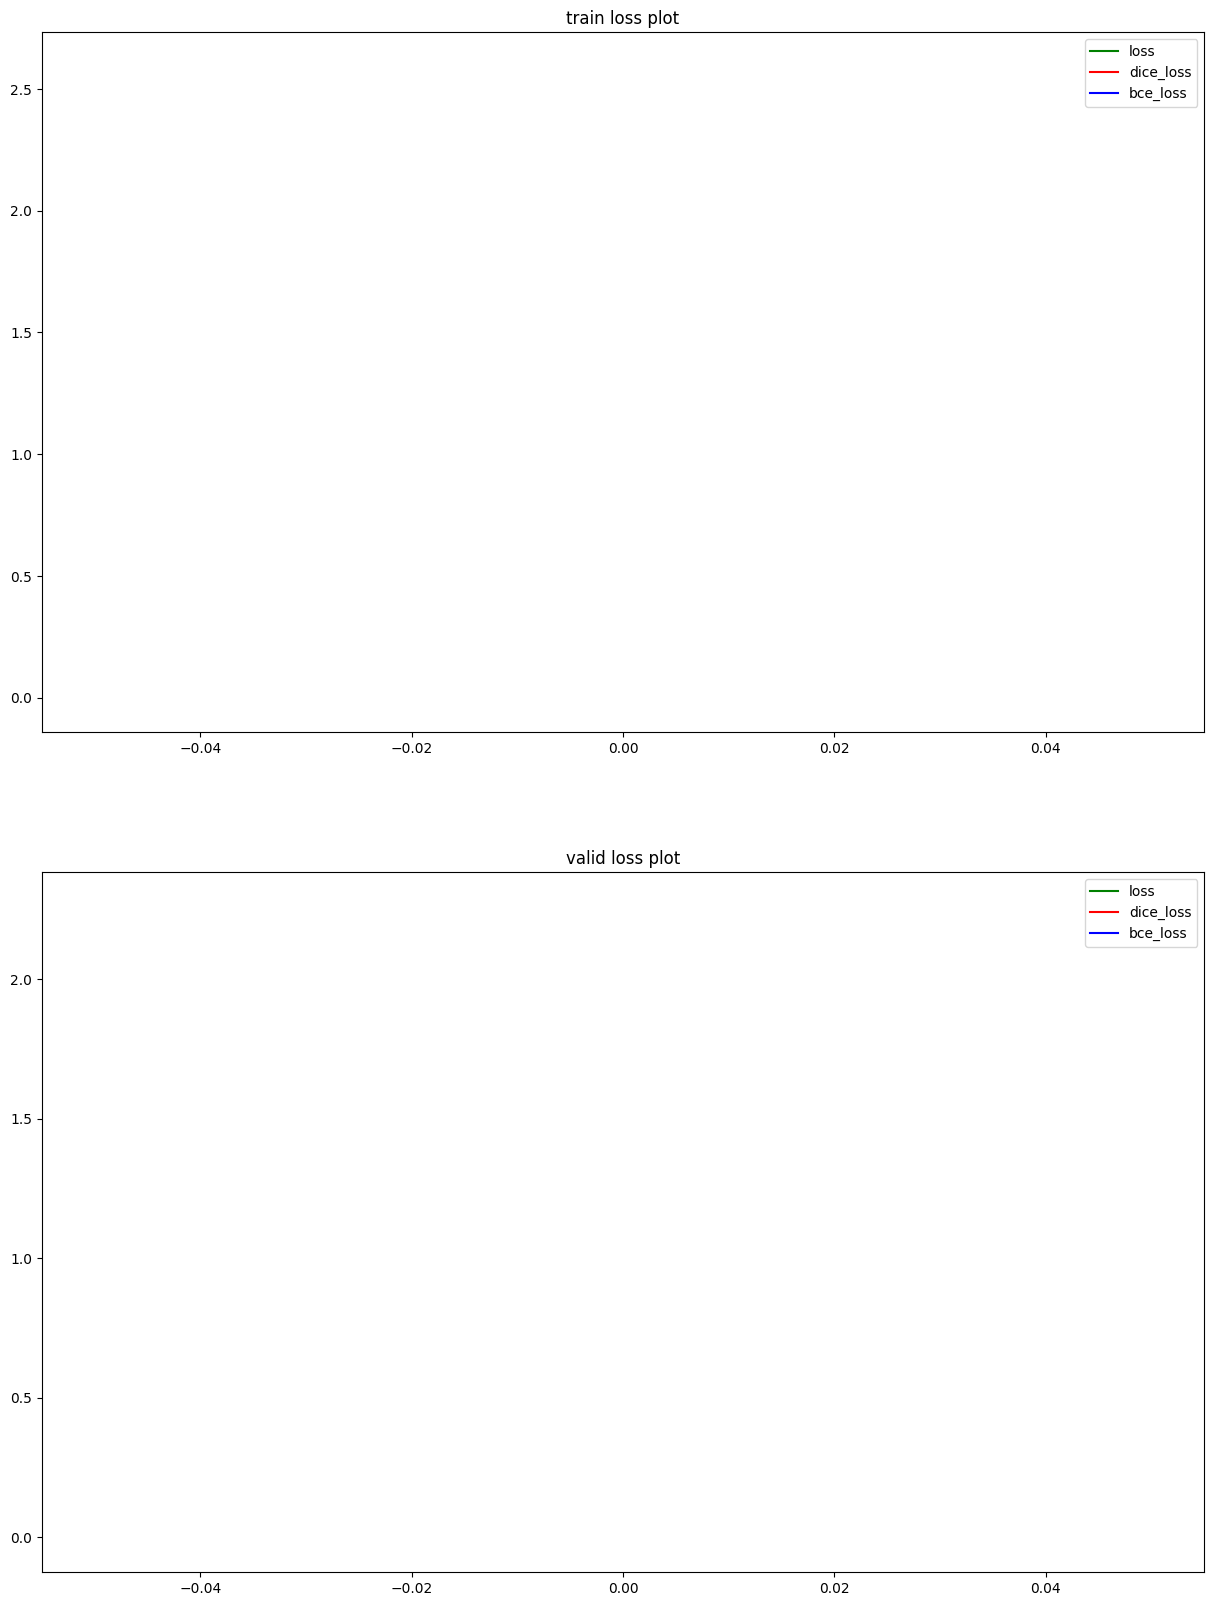

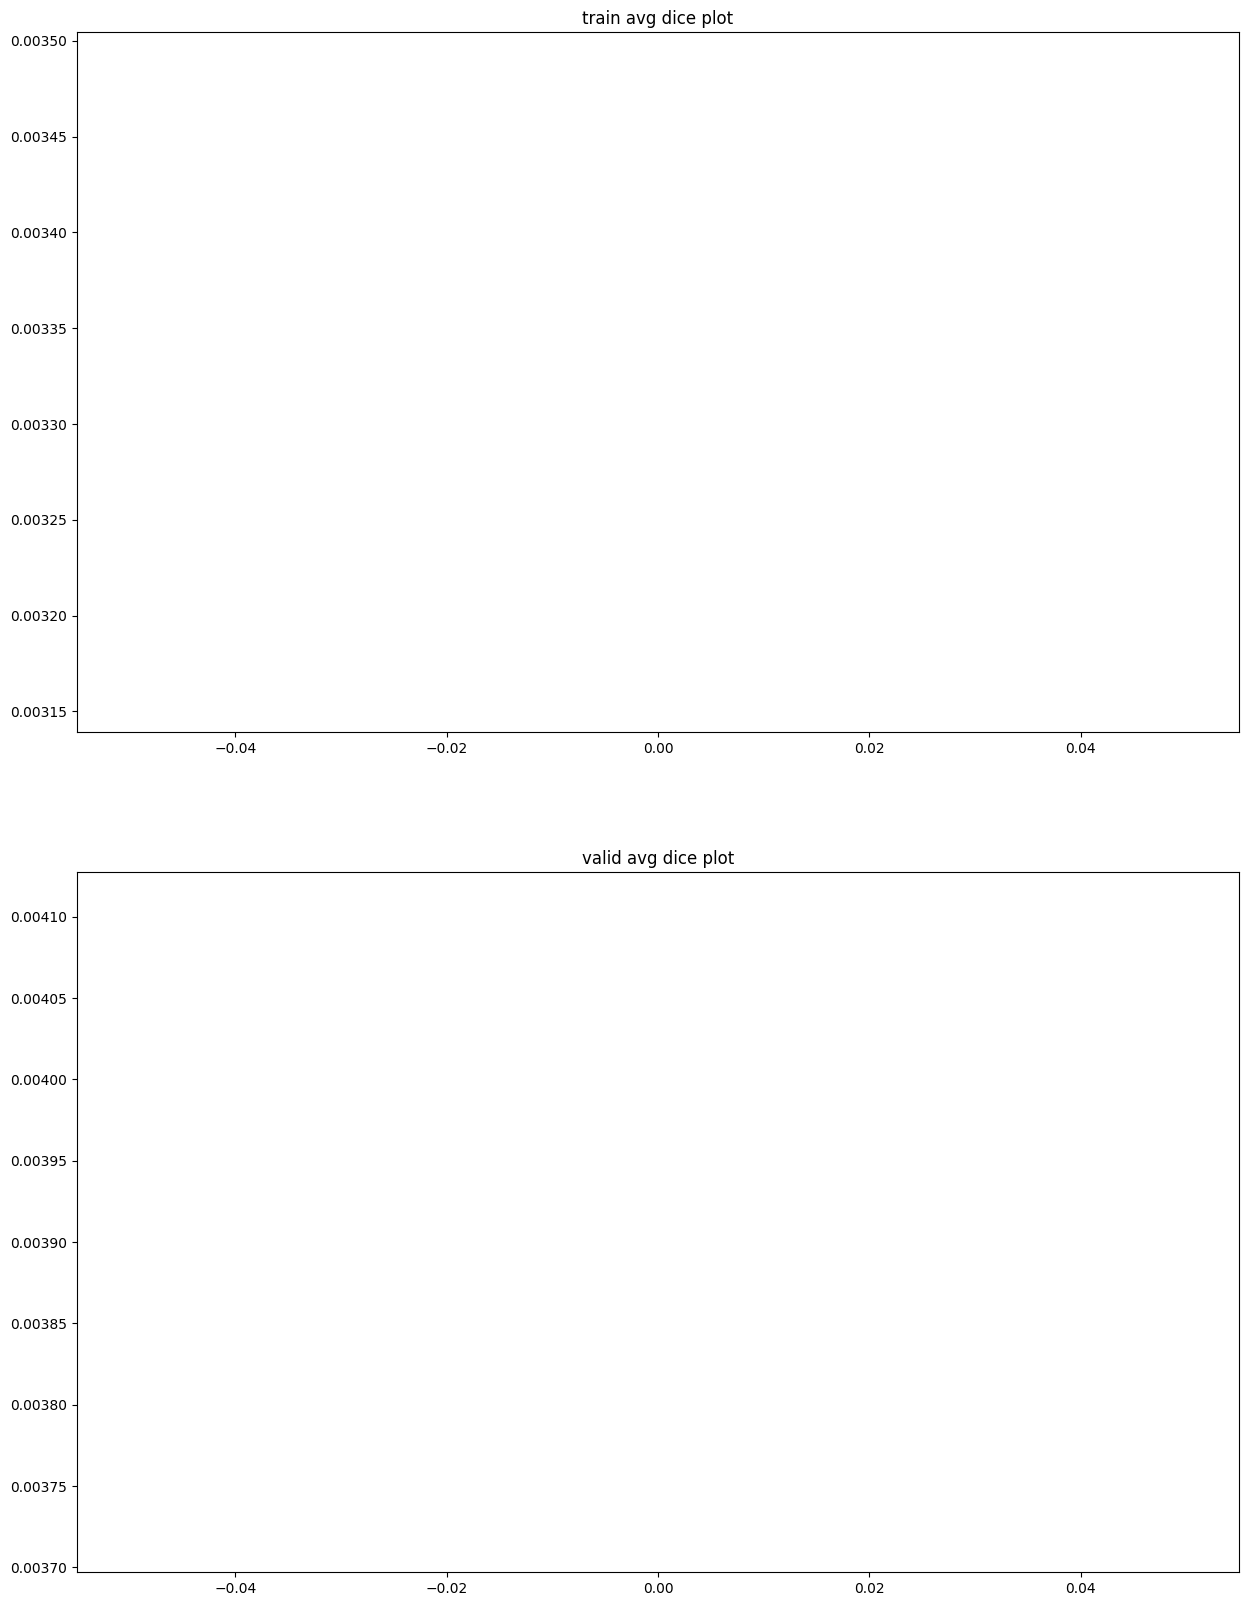

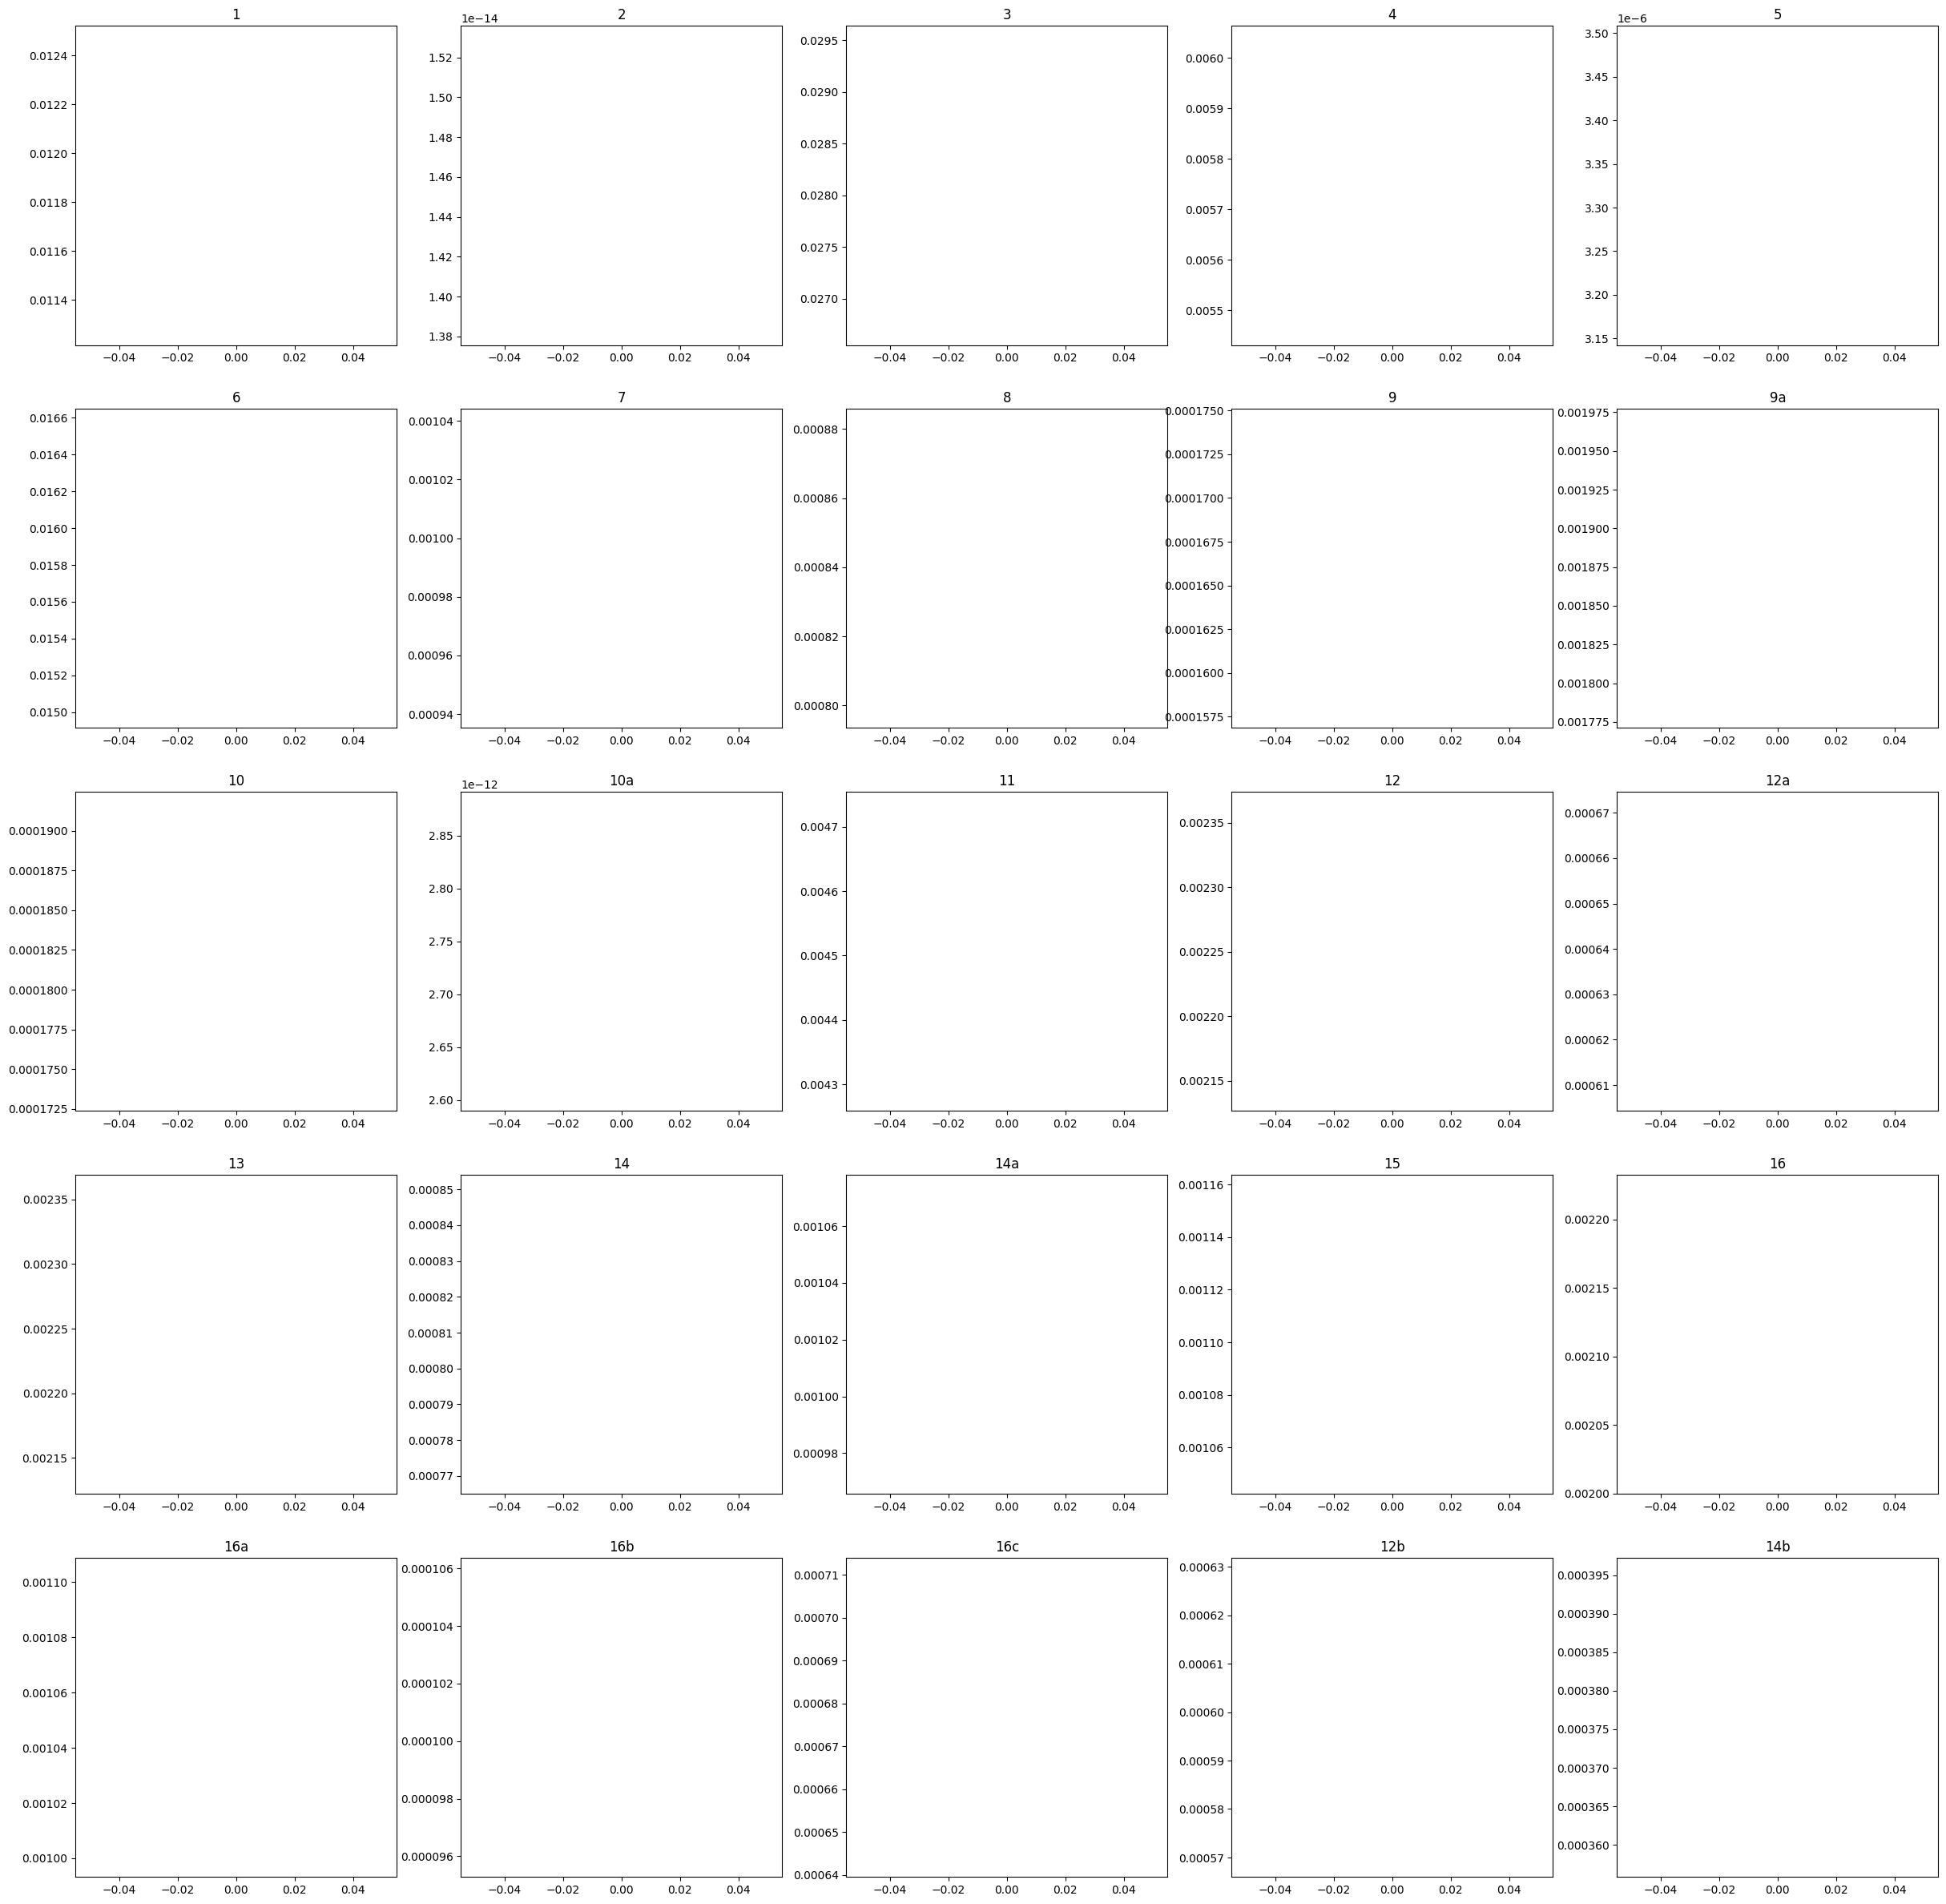

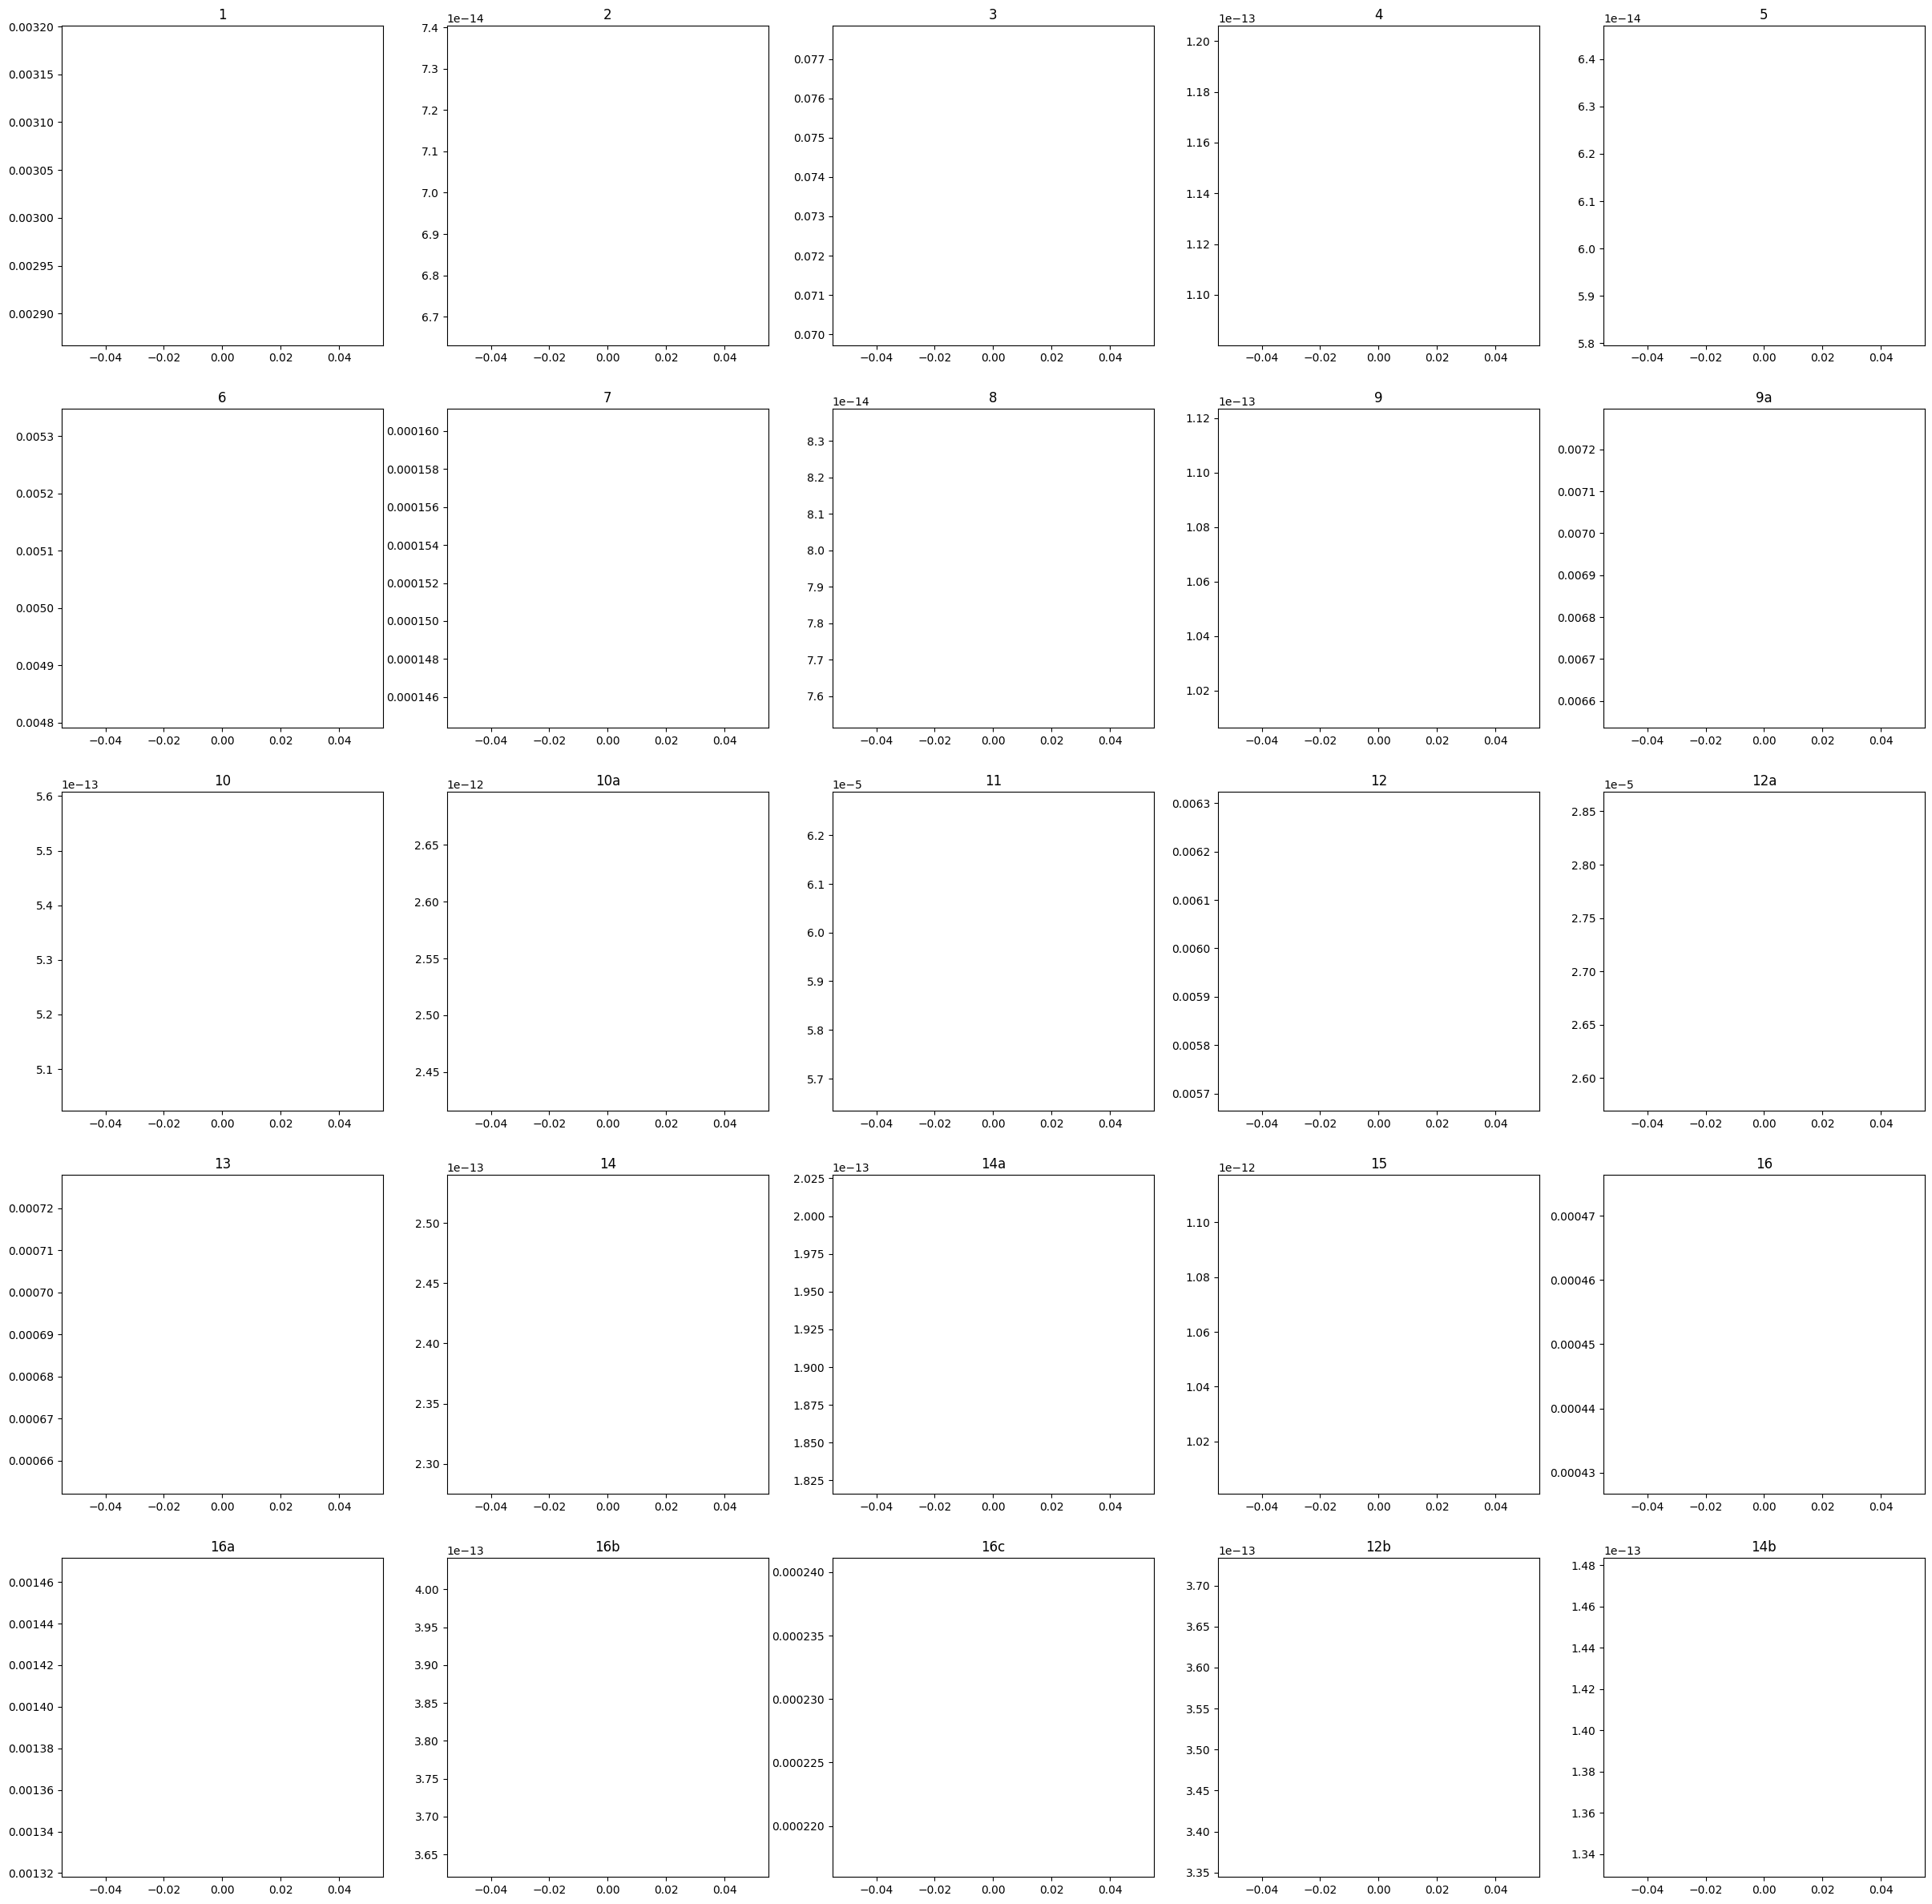

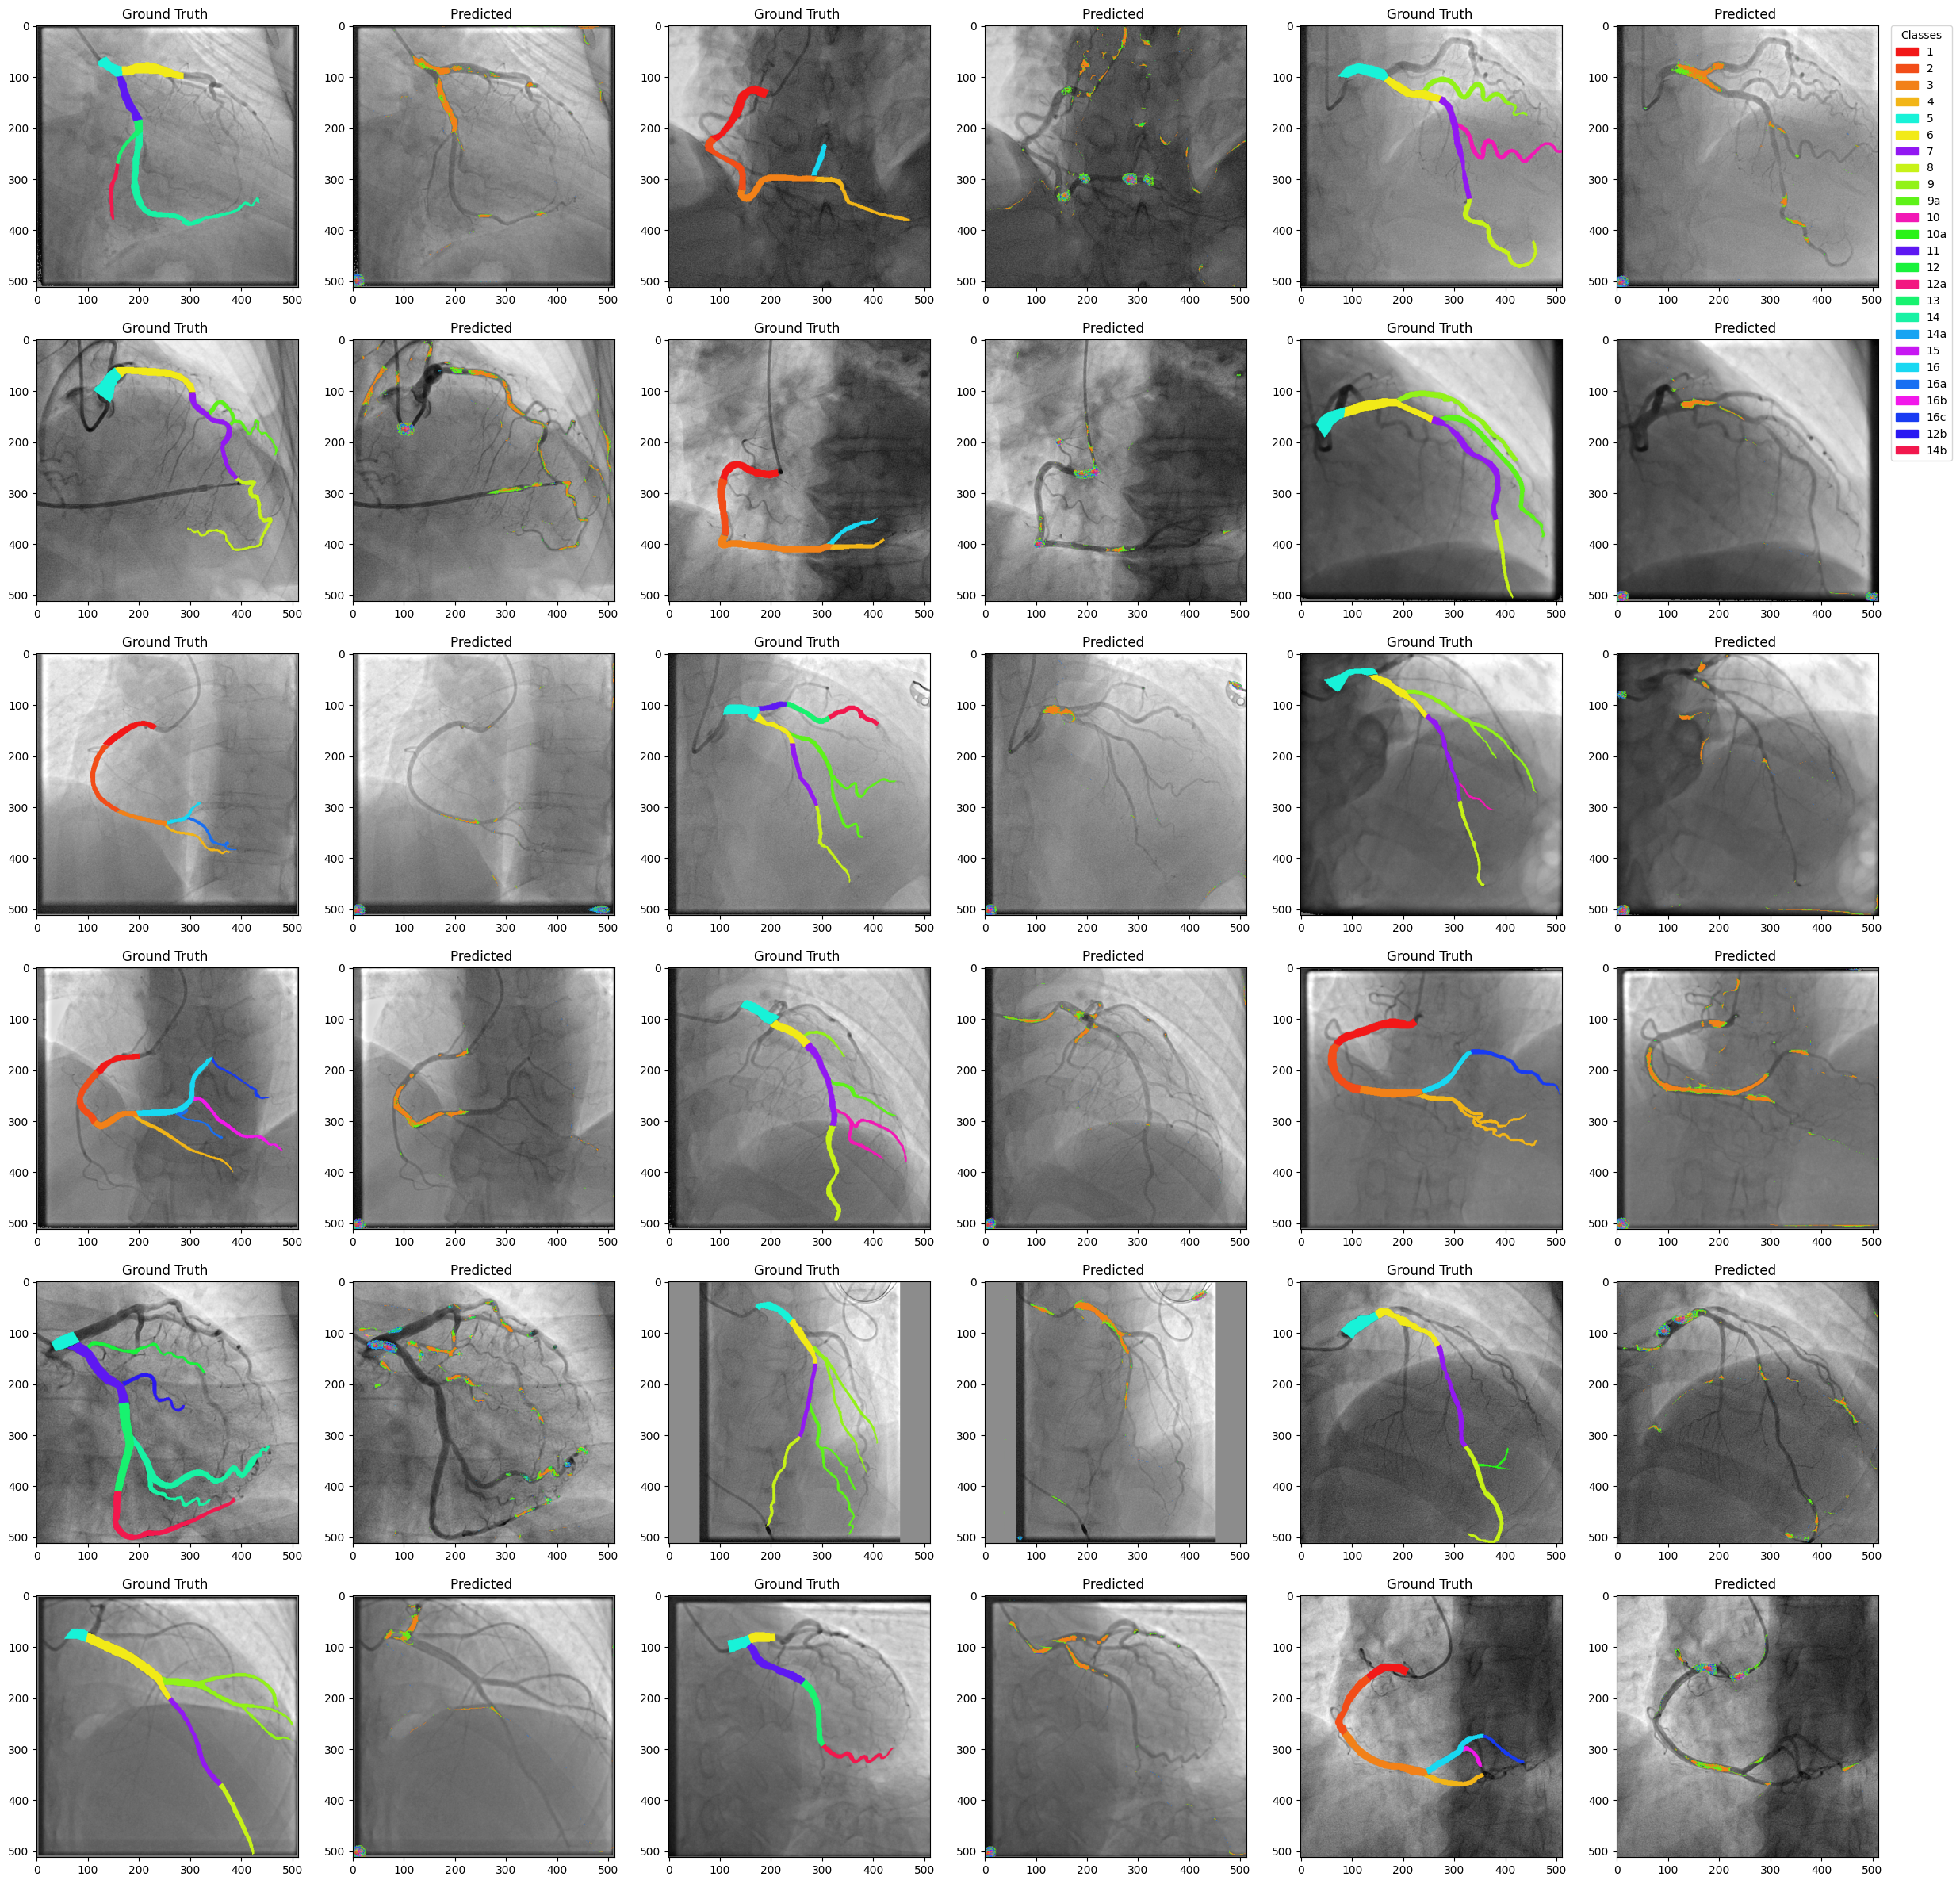

In [7]:
save_full_report(
    recorder= recorder , 
    output_base_path=args["output_base_path"],
    model=model,
    valid_loader=valid_loader,
    args=args,
    class_map=class_map,
    name=args["name"]
)